# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler, OneHotEncoder

import tqdm


In [2]:
STATE = np.random.RandomState(12345)

## Подготовка данных

In [3]:
try:
    data = pd.read_csv('path_to/autos.csv')
    print('Прочитали данные с диска')
except:
    data = pd.read_csv('/datasets/autos.csv')
    print('Прочитали данные в сети')

Прочитали данные в сети


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Датасет содержит 16 полей, 354369 строк. 5 полей содержат пустые значения (пропуски).

Названия полей приведу к "питоновскому стилю" - добавление нижних подчеркиваний, запись в нижнем регистре

Изменим названия полей и посмотрим первые 10 строк.

In [6]:
data.rename(columns={'DateCrawled':'Date_Crawled','VehicleType':'Vehicle_Type',
                     'RegistrationYear':'Registration_Year',
                    'RegistrationMonth':'Registration_Month','FuelType':'Fuel_Type',
                    'DateCreated':'Date_Created','NumberOfPictures':'Number_Of_Pictures',
                     'PostalCode':'Postal_Code','LastSeen':'Last_Seen'
                   }, inplace = True)
# переведем в нижний регистр
data.columns = data.columns.str.lower()

In [7]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Поменяем формат полей дат с object на дату

In [8]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'])
data['date_created'] = pd.to_datetime(data['date_created'])
data['last_seen'] = pd.to_datetime(data['last_seen'])

Запишу исходное количество строк и создам функцию, которая будет показывать на сколько уменьшается датасет при очередной манипуляции удаления строк.

In [9]:
rowb = data.shape[0] # начальное количество строк
rowl = rowb          # последнее (перед манипуляцией) количество строк

In [10]:
def change_count(data):
    rowch = data.shape[0]
    change_total = (rowb-rowch)/rowb
    change_last = (rowl-rowch)/rowl
    print_string = ('{:,.2%}'.format(change_total)+
      ' / '+'{:,.2%}'.format(change_last))
    print('Исходный / последний / измененный размеры:',rowb,' / ',rowl,' / ',rowch)
    print('Общее / последнее уменьшение датасета:',print_string)

Создам список названий списков, которые будут создаваться в ходе проекта, чтобы потом не листать тетрадь

In [11]:
llist = []

In [12]:
# список категориальных полей
list_cat = ['vehicle_type','gearbox','model','fuel_type','brand','repaired','postal_code'] # 7 шт
# поля даты
list_date = ['date_crawled','date_created','last_seen'] # 3 шт
# числовые поля
list_dig = ['price','registration_year','power','kilometer','registration_month',
                                                                'number_of_pictures'] # 6 шт
llist = llist + ['list_cat','list_date','list_dig']

In [13]:
llist

['list_cat', 'list_date', 'list_dig']

Посмотрим и удалим дубликаты

In [14]:
print('Количество дубликатов в выборке',data.duplicated().sum())
data = data.drop_duplicates()

Количество дубликатов в выборке 4


In [15]:
change_count(data)
rowl = data.shape[0]

Исходный / последний / измененный размеры: 354369  /  354369  /  354365
Общее / последнее уменьшение датасета: 0.00% / 0.00%


### Обработка пропусков

Посмотрим на совместное появление пропусков.

In [16]:
# 0. Функция для создания общей сводной таблицы
def summary_table():
    df = pd.DataFrame({'col_null_count':data.isna().sum()},index=data.isna().sum().index)
    df['col_type']=data.dtypes
    df = df.join(data.describe().transpose())
    df['mean_median']=(df['mean']-df['50%'])/df['50%'] # превышение среднего над медианой
    df_style = {'count':'{:.0f}','mean':'{:.2f}','mean_median':'{:.2%}', # словарь для форматирования вывода
                'std':'{:.2f}','min':'{:.1f}','25%':'{:.1f}','50%':'{:.1f}','75%':'{:.1f}','max':'{:.1f}'}
    return df, df_style
# df, df_style = summary_table()
# df.style.format(df_style)

In [17]:
# I. создадим функцию для построения матрицы совместного появления пропусков
def null_matrix(cutoff):
    df, df_style = summary_table()
    null_list = df[df['col_null_count'] != 0].index # список полей с пропусками
    mis_matrix = pd.DataFrame(index=null_list)      # датафрейм - матрица
    cutoff_list = []

    for base in null_list:                          # пройдем по списку полей с пропусками
        calc_base = df.loc[base]['col_null_count']
        for calc in null_list: # для каждого такого поля еще пройдем по списку полей с пропусками
            calc_mis = len(data.loc[(data[base].isna()) & 
                                    (data[calc].isna())][calc])/calc_base # доля совпадающих пропусков
            mis_matrix.at[base,calc] = calc_mis
    for base in null_list: # еще раз пройдем по матрице, чтобы убрать значения меньше занной отсечки cutoff
        for calc in null_list:
            if mis_matrix.loc[base,calc] < cutoff or mis_matrix.loc[calc,base] < cutoff or calc == base:
                # значения меньше уровня отсечки в матрице будем обнулять
                # значение 1 в диагонали матрицы будем обнулять.
                mis_matrix.loc[base,calc] = 0
                mis_matrix.loc[calc,base] = 0
            elif base not in cutoff_list:
                cutoff_list.append(base)

    cutoff_matrix = pd.DataFrame(index=cutoff_list) # сокращенная после отсечки матрица совместных пропусков
    for base in cutoff_list:
        for calc in cutoff_list:
            cutoff_matrix.at[base,calc] = mis_matrix.loc[base,calc]
            if base == calc:
                cutoff_matrix.at[base,calc] = 1
    return cutoff_matrix

Посмотрим на долю пустых значений в полях с пропусками

In [18]:
data.isna().sum()[data.isna().sum()/data.shape[0]!=0]/data.shape[0]

vehicle_type    0.105795
gearbox         0.055968
model           0.055607
fuel_type       0.092828
repaired        0.200793
dtype: float64

Посмотрим матрицу совместного появления пропусков. Уровень отсечения установим равным нулю (т.е. смотрим все возможные пересечения множеств)

In [19]:
null_matrix(0.0)

,vehicle_type,gearbox,model,fuel_type,repaired
vehicle_type,1.000000,0.265938,0.182129,0.461323,0.548706
gearbox,0.502698,1.000000,0.208289,0.449755,0.644784
model,0.346511,0.209642,1.000000,0.363512,0.459477
fuel_type,0.525764,0.271166,0.217753,1.000000,0.504058
repaired,0.289105,0.179723,0.127245,0.233030,1.000000


Видим, что:
- 100% совпадения пропусков ни по каким парам полей нет, т.е. явной технической причины появления пропусков (например при копировани одновременно не записываются значения сразу для пары или более полей в одних и тех же строках) нет.
- пропуски в поле repaired покрывают половину и более пропусков в других полях.
- все пропуски относятся к категориальным признакам.

Можно предположить, что значительная часть пропусков связана с особенностями заполнения карточек объявлений (вероятно, достаточно часто человек может просто пропускать при заполнении указания одновременно полей gearbox, fuel_type, vehicle_type, repaired)

Выявить явные закономерности для понятного заполнения пропусков, пользуясь только данными самого датасета не представляется возможным. Конечно, можно использовать (построить) дополнительные модели для определения значений в указанных полях (что вроде классификации или, например, регрессию для repaired по пробегу), но это не входит в рамки данного исследования. Поэтому заменим пропуски значением "n_a"

In [20]:
data = data.fillna('n_a')
data.isna().sum()[data.isna().sum()/data.shape[0]!=0]/data.shape[0]

Series([], dtype: float64)

### Обработка аномалий

Создам функцию, пердставляющую "обрезаные" по перцентилям поля

In [21]:
def rez(data,clmn,qmn,qmx):
    out = data[(data[clmn]<=data[clmn].
   quantile(qmx)) & (data[clmn]>=data[clmn].
   quantile(qmn))][clmn]
    return out

Посмотрю распределение значений по полям с числами и датами

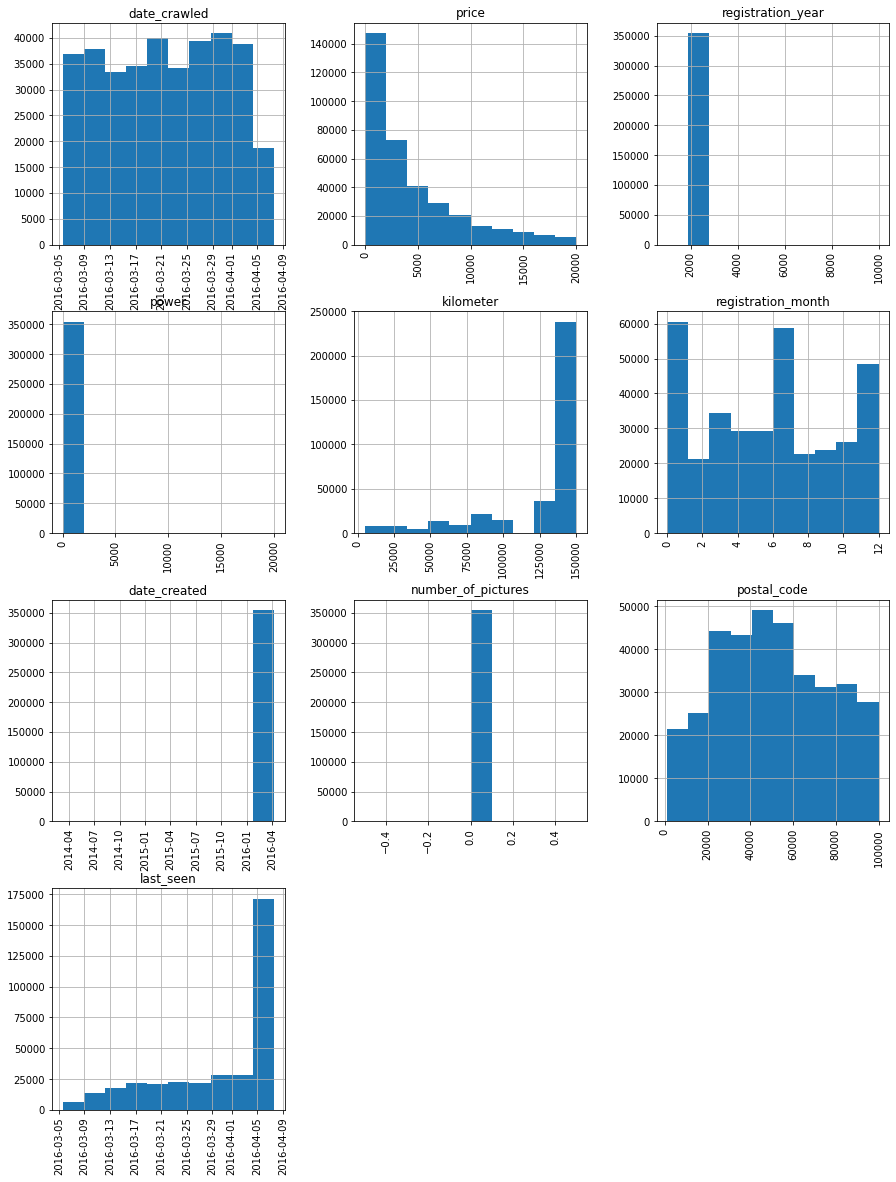

In [22]:
ax = data.hist(figsize=(15,20), xrot=90)
plt.show()

#### Нули в поле price
Очевидно, нули в поле цены - это аномальные значения

In [23]:
print('Количество ТС без цены:',data[data['price']<=0]['price'].count())

Количество ТС без цены: 10772


In [24]:
# удалим такие поля
data = data[data['price']>0]

In [25]:
change_count(data)
rowl = data.shape[0]

Исходный / последний / измененный размеры: 354369  /  354365  /  343593
Общее / последнее уменьшение датасета: 3.04% / 3.04%


#### Аномалии registration_year, power, date_created, number_of_pictures

Видим, что поля registration_year, power, date_created, number_of_pictures возможно имеют аномалии 

Выведем гистограммы для данных полей по их усеченным значениям (перцентили- более 0,1% и менее 99,9%)

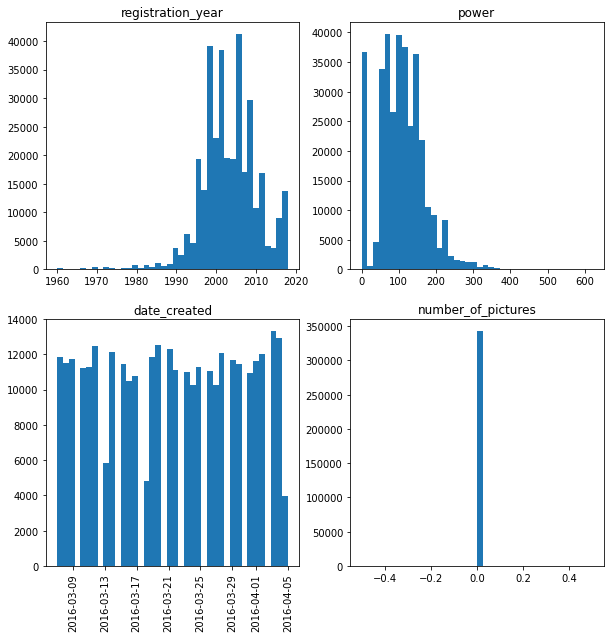

In [26]:
figure, axis = plt.subplots(2, 2, figsize=(10,10))
axis[0,0].hist(rez(data,'registration_year',0.001,0.999),bins=40)
axis[0,0].set_title('registration_year')
axis[0,1].hist(rez(data,'power',0.001,0.999),bins=40)
axis[0,1].set_title('power')
axis[1,0].hist(rez(data,'date_created',0.05,0.995),bins=40)
axis[1,0].set_title('date_created')
axis[1,0].tick_params(axis='x', labelrotation=90)
axis[1,1].hist(rez(data,'number_of_pictures',0.01,0.99),bins=40)
axis[1,1].set_title('number_of_pictures')
plt.show()


Видим, что такое отсечение дает вполне адекватные распределения.

"Смущает" количество фотографий. Посмотрим список уникальных значений по полю

In [27]:
data['number_of_pictures'].unique()

array([0])

Очевидно, значения данного поля были скопированы в датасет с ошибками. Поле не информативно, поэтому удалю данный столбец.

In [28]:
data = data.drop(['number_of_pictures'],axis=1)

In [29]:
list_dig.remove('number_of_pictures')

Разберемся со значениями в поле date_created.

Очевидно, что дата не может быть старше максимального значения в поле date_crawled.

In [30]:
data[data['date_created']>data['date_crawled'].max()].shape[0]

0

С верхней границей date_created все нормально. Нижнюю границу значений трогать не буду, т.к. нижний хвост, который искажает распределение незначительный по объему (0.01%). И при этом самая ранняя дата в поле относится к 2014 г., что явлается адекватным значением.

Рассмотрим поле registration_year. На год также должно действовать ограничение: максимальное значение д.б. не больше максимума для date_crawled

In [31]:
max_year = data['date_crawled'].dt.year.max()
display(data[(data['registration_year']>max_year)]['registration_year'].unique())
print('Доля значений, превышающих допустимое:',data[(data['registration_year']>max_year)]
                                  ['registration_year'].count()/data.shape[0])

array([2018, 2017, 5000, 3200, 9999, 8888, 2200, 4100, 3000, 2066, 2019,
       8000, 5300, 9000, 2900, 6000, 5900, 5911, 4000, 8500, 3700, 3800,
       4800, 7000, 6500, 2290, 9450, 2500, 5555, 5600, 2222, 2800, 4500,
       7800, 7100, 8200])

Доля значений, превышающих допустимое: 0.040102679623857294


Видим, что превышения составляют 4.1% от датасета. Скорее всего это ошибки заполнения, но также для 2017, 2018 это могут быть ошибки копирования. Выявить истинные значения на основании исходной информации не предсталяется возможным. Удалим строки с такими превышениями

Также на гистограмме выше видно, что при отсечении нижнего перцентиля (0,1%) мы получаем вполне адекватные значения годов для автомобилей: от 1960. Поэтому также удалим строки ниже такого перцентиля.

In [32]:
data = data[(data['registration_year']<max_year) &
            (data['registration_year']>data['registration_year'].quantile(0.001))]

In [33]:
# посмотрим на сколько уменьшили датасет
change_count(data)
# обновим последний размер датасета
rowl = data.shape[0]

Исходный / последний / измененный размеры: 354369  /  343593  /  320370
Общее / последнее уменьшение датасета: 9.59% / 6.76%


Разберемся с мощностью. Посмотрим состав значений самого малого перцентиля, в который попадают хоть какие то значения. Получим 11% перцентиль.

In [34]:
qmn=data['power'].quantile(0.11)
display(data[data['power']<qmn]['power'].value_counts().sort_index())
data[data['power']==0]['power'].count()/rowl

0     30079
1        24
2         8
3         8
4        30
5        96
6        11
7        10
8         6
9         4
10        8
11       27
12        9
13        6
14       19
15       15
16        5
17        7
18       48
19        9
20       17
21        2
22        3
23       35
24       25
25       14
26      252
27       37
28        5
29       32
30       19
31        7
32        2
33       48
34      165
35       10
36        5
37       42
38       10
39      120
40      278
41      421
42       44
43      101
44      350
45     2617
46       52
47       29
Name: power, dtype: int64

0.09388831663389206

Видим, что отрицательных значений нет. Доля нулей 10%. При этом есть авто с низкими (менее 40 лс) значениями мощности. Посмотрев их по отдельности (не привожу здесь выкладки для краткости), видим, что некоторые значения - могут быть как ошибочными (возможно указаны цифры без нулей) так и реальными- например 26 и 34 лс- реальные и соответствуют определенным моделям ТС.

Удалю строки с мощностью менее 39 и не равной 0, 26 и 34 лс.

Также удалю строки верхнего 99,9% перцентиля, где указана мощность более 700 лс, что очевидно является либо ошибкой, либо очень редким - аномальным значением

In [35]:
data = data[(data['power']==0) | (data['power']==26) | (data['power']==34) | ((data['power']>=39) &
     (data['power']<data['power'].quantile(0.999)))]

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Удалю нули. Хотя, я думаю, нули информативны, поскольку - это 10% датасета, и они законны- как показано ниже. В реальных данных их игнорирование вырежет большой кусок валидных данных. Но тем не менее. Исследование оставляю. Удаление будет ниже - за ним.
   </font>
</div>

In [36]:
# посмотрим на сколько уменьшили датасет
change_count(data)
# обновим последний размер датасета
rowl = data.shape[0]

Исходный / последний / измененный размеры: 354369  /  320370  /  319386
Общее / последнее уменьшение датасета: 9.87% / 0.31%


Обработаю значения нулевых мощностей. Хотя теоретически может встречаться продажа ТС без двигателя, но, скорее всего это не может происходить в 10% случаев. Разберемся.

In [37]:
data[data['power']==0].shape[0]

30079

In [38]:
# посмотрим как представлены типы топлива для нулевой можности
data[data['power']==0]['fuel_type'].value_counts()

petrol      15484
n_a          7591
gasoline     6562
lpg           310
other          61
cng            44
hybrid         16
electric       11
Name: fuel_type, dtype: int64

Видим, что основная часть объявлений с нулевой мощностью относится к топливным моторам.
Непонятно - это объявления с ошибками или какие то машины продаются без моторов. Проверим гипотезу о равенстве средних для выборок объявлений с ненулевой и с нулевой мощностью.

In [39]:
# создадим датафрем со всеми парами брэнд-модель
models = data[data['power']==0][['brand','model']].value_counts().reset_index()\
.sort_values(by=['brand','model']).reset_index()
models['count_0'] = 0 # zero power count
models['count_1'] = 0 # not zero count
models['p_value'] = 10 # аномальное значение по умолчанию
models['avg_price_0'] = 0 # average price for zeros
models['avg_price_1'] = 0 # avg price for not zeros

In [40]:
# пройдем по тестам для репрезентативных выборок
i =0
for row in tqdm.tqdm(models.itertuples()):
    b, m = row.brand, row.model
    pr_0 = data[(data['power']==0) & (data['brand']==b) & (data['model']==m)]['price']
    pr_1 = data[(data['power']!=0) & (data['brand']==b) & (data['model']==m)]['price']
    models.loc[row[0],'count_0'] = pr_0.count()
    models.loc[row[0],'count_1'] = pr_1.count()
    models.loc[row[0],'avg_price_0'] = pr_0.mean()
    models.loc[row[0],'avg_price_1'] = pr_1.mean()
#     print(models.loc[row[0]][['brand','model']])
    if pr_1.shape[0]>30 and pr_0.shape[0]>30:
        result = st.ttest_ind(pr_0,pr_1,equal_var=False)
        models.loc[row[0],'p_value'] = result.pvalue
        i +=1
print(i)

326it [02:37,  2.07it/s]

146


In [41]:
del pr_0, pr_1

Из общего количества пар (брэнд, модель) с наличием нулевых мощностей под ттест попало менее половины всех пар

In [42]:
models[models['p_value']<0.05]['p_value'].count()

133

Под уровень значимости 5% попадают еще немного меньше.

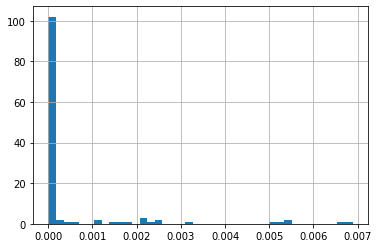

In [43]:
# Посмотрим распределение p_value
models[models['p_value']<0.01]['p_value'].hist(bins=40);

Видим, что в основном для репрезентативных выборок критерий значимости находится около нуля. Т.е. на основании ттеста можно говорить о том, что отсутствие мощности статистически значимо влияет на цену.

Посморим также расхождения между средними ценами выборок

In [44]:
models['avg_diff']=(models['avg_price_1']-models['avg_price_0'])/models['avg_price_0']

In [45]:
models[models['p_value']<0.01]['avg_diff'].mean()

0.8263590437524166

В среднем для статистически различающихся выборок среднее значение цен для ТС с мощностью не равной 0 больше такого же значения для ТС с нулевой мощностью почти в 2 раза.

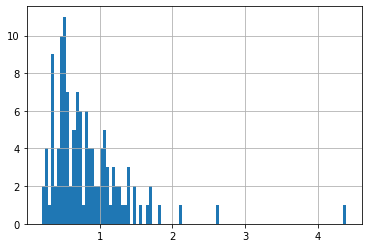

In [46]:
models[models['p_value']<0.01]['avg_diff'].hist(bins=100);

На гистограмме видно заметное (значительное: от 30% и выше) расхождение средних значений цен для выборок.

Конечно для большей уверенности необходимо сравнивать еще более глубже определенные классы (выделять классы по пробегу, и другим категориям), но для данного датасета недостаточно данных для получения репрезентативных выборок.

Поэтому делаю вывод, что нулевая мощность (для ТС с p_value<5% в рамках тестов проведенных выше) говорит о ТС без двигателя, либо о ТС с нерабочим двигателем.

Поэтому значения нулей для таких пар (брэнд, модель) менять не буду. Для тех пар ТС, по которым разница между средним значением цены (между подклассами с нулевой и ненулевой мощностью) меньше 15%, заменю значения нулевой мощности на моду по мощности в паре (брэнд, модель)

In [47]:
# создадим датафрейм с агреггированными по брэнду модели данными по мощности
d_pow = data[data['power']!=0].groupby(['brand', 'model'])['power']\
            .agg(lambda x: x.mode().iloc[0]).reset_index()

In [48]:
# оставим только модели с "небольшой" разницей в средней цене между подклассами
d_pow = d_pow.merge(models[models['avg_diff']<0.15],on = ['brand', 'model'])[['brand','model','power']]

In [49]:
# объеденим датафреймы для замены нулей
d_0 = data.merge(d_pow, on = ['brand', 'model'],how='left')[['power_x','power_y']]
# установим индекс исходного датафрейма
d_0.set_index(data.index, inplace=True)
d_0.shape[0]

319386

In [50]:
# заменим нули по мощности модой (там где есть такие значения)
# idx = d_0[(d_0['power_x'] == 0) & (d_0['power_y'].notna())].index
# display(len(idx))
# data.loc[idx,'power'] = d_0.loc[idx,'power_y']

In [51]:
data[data['power']==0].shape[0]

30079

In [52]:
del d_0

Осталось 29К нулей. Как показано выше эти нули статистически "законны" и их замена числом исказит распределение значений признака.

In [53]:
# теперь удалим нули
data = data[data['power']!=0]

### Обработка категориальных признаков

Поскольку существуют модели ТС одинаковые для разных брэндов объединю брэнд и модель в один признак

In [54]:
data['brand_model'] = data['brand']+'___'+data['model']

In [55]:
data['brand_model'].nunique()

336

In [56]:
list_cat.remove('brand')
list_cat.remove('model')

In [57]:
list_cat.append('brand_model')

#### Почтовый индекс
разберемся с полем postal_code

In [58]:
# посмотрим количество уникальных значений
data['postal_code'].nunique()

8108

Почтовый индекс является категориальным признаком. При кодировании такого числа значений мы во-первых получим огромное число OHE признаков, во-вторых слишком мелкая классификация по округу скорее всего не позволит найти закономерности на уровне штата (хотя в некоторых случаях конкретные, как правило наиболее богатые округа могли бы являтся качественным признаком). Поэтому уменьшим количество:
оставим от индексов только тысячные разряды

In [59]:
data['postal_code_s'] = data['postal_code'] // 1000
data['postal_code_s'].nunique()

95

In [60]:
data['postal_code'].sort_values().unique()

array([ 1067,  1068,  1069, ..., 99994, 99996, 99998])

In [61]:
data['postal_code_s'].sort_values().unique()

array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

Такое количество увеличит сложность вычислений. Поэтому получим категории для более крупных регионов

In [62]:
def get_macroregion(postal_code):
    if 1000 <= postal_code <= 30000:
        return 'NE'
    elif 30000 <= postal_code < 50000 or 70000 <= postal_code < 79999:
        return 'S'
    elif 90000 <= postal_code <= 99999 or 80000 <=  89999:
        return 'W'
    elif 50000 <= postal_code <= 56999:
        return 'NC-E'
    elif 57000 <= postal_code <= 59999:
        return 'NC-W'
    else:
        return 'Other'

In [63]:
data['macroregion'] = data['postal_code'].apply(get_macroregion)

In [64]:
data['macroregion'].unique()

array(['W', 'S', 'NE'], dtype=object)

In [65]:
list_cat.remove('postal_code')
list_cat.append('macroregion')

In [66]:
list_cat

['vehicle_type',
 'gearbox',
 'fuel_type',
 'repaired',
 'brand_model',
 'macroregion']

#### Объединение категорий

Посмотрю редко встречающиеся значения в полях категориальных признаков для их объединения с целью уменьшения количества признаков при ОНЕ кодировании

In [67]:
data['vehicle_type'].value_counts(normalize=True)

sedan          0.286578
small          0.240644
wagon          0.204700
bus            0.090523
convertible    0.064689
coupe          0.050355
suv            0.037735
n_a            0.016502
other          0.008275
Name: vehicle_type, dtype: float64

В данном поле ничего объединять не буду

In [68]:
data['gearbox'].value_counts(normalize=True)

manual    0.782729
auto      0.200538
n_a       0.016733
Name: gearbox, dtype: float64

Также не трогаю это поле

In [69]:
data['fuel_type'].value_counts(normalize=True)

petrol      0.636293
gasoline    0.300359
n_a         0.044620
lpg         0.016004
cng         0.001645
hybrid      0.000684
other       0.000277
electric    0.000118
Name: fuel_type, dtype: float64

Объединю категории с долей < 1%

In [70]:
idx = data[(data['fuel_type']=='cng') | (data['fuel_type']=='hybrid') | (data['fuel_type']=='other')
    | (data['fuel_type']=='electric')].index
data.loc[idx,'fuel_type'] = 'rare'

In [71]:
data['repaired'].value_counts(normalize=True)

no     0.764859
n_a    0.138420
yes    0.096721
Name: repaired, dtype: float64

В поле repaired ничего не меняем

In [72]:
p = data['macroregion'].value_counts(normalize=True)
p

W     0.411646
S     0.349708
NE    0.238646
Name: macroregion, dtype: float64

Удаляю. Только не само поле, а название поля из списка полей

In [73]:
list_cat.remove('macroregion')

In [74]:
list_cat

['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'brand_model']

##### Брэнд, модель

In [75]:
# посмотрим долю каждой пары (брэнд, модель) в общем датасете
p = data['brand_model'].value_counts(normalize=True).reset_index()
p.rename(columns={'brand_model':'bm_frac','index':'brand_model'}, inplace = True)
# посмотрим долю по брэнду
p[['brand', 'model']] = p['brand_model'].apply(lambda x: pd.Series(str(x).split('___')))
# посмотрим долю модели в брэнде
p = p.merge(p.groupby('brand')['bm_frac'].sum().reset_index(),on=['brand'],how='left')
p['model_frac']= p['bm_frac_x']/p['bm_frac_y']
# отберем мелкие модели внутри брэнда
# pd.set_option('display.max_rows', None)
display(p[p['model_frac']<0.05])
# pd.reset_option('display.max_rows')

,brand_model,bm_frac_x,brand,model,bm_frac_y,model_frac
22,volkswagen___touran,0.009882,volkswagen,touran,0.215221,0.045917
29,volkswagen___lupo,0.007155,volkswagen,lupo,0.215221,0.033245
33,volkswagen___n_a,0.006453,volkswagen,n_a,0.215221,0.029985
39,bmw___x_reihe,0.004912,bmw,x_reihe,0.110101,0.044611
42,volkswagen___caddy,0.004400,volkswagen,caddy,0.215221,0.020445
...,...,...,...,...,...,...
331,rover___discovery,0.000007,rover,discovery,0.001220,0.005666
332,land_rover___range_rover_evoque,0.000007,land_rover,range_rover_evoque,0.001593,0.004338
333,rover___rangerover,0.000007,rover,rangerover,0.001220,0.005666
334,rover___freelander,0.000003,rover,freelander,0.001220,0.002833


Заменим названия редких моделей на smallest

In [76]:
p['model_small'] = p['model']
p.loc[p[p['model_frac']<0.05].index,'model_small']='smallest'
p['brand_model_small'] = p['brand']+'___'+p['model_small']

In [77]:
data.shape[0]

289307

In [78]:
data_bm = \
data.merge(p[['brand','model','brand_model','brand_model_small']],\
           on=['brand_model'],how='left')
data_bm.set_index(data.index, inplace=True)

In [79]:
print('Количесво пар (брэнд, модель):',data_bm['brand_model_small'].nunique())

Количесво пар (брэнд, модель): 220


In [80]:
list_cat.remove('brand_model')
list_cat.append('brand_model_small')
list_cat

['vehicle_type', 'gearbox', 'fuel_type', 'repaired', 'brand_model_small']

In [81]:
data['brand_model_small'] = data_bm['brand_model_small']
del data_bm

In [82]:
data['brand_model_small'].nunique()

220

#### Даты - поля с датами не использую

В датасете 3 поля с датой-временем.
- DateCrawled — дата скачивания анкеты из базы - считаю, никак не может влиять на цену, поэтому удаю данное поле
- DateCreated — дата создания анкеты- может влиять на цену (теоретически, чем старее анкета, тем скорее цена может быть ниже для аналогичной в классе- но это не точно)
- LastSeen — дата последней активности пользователя - не знаю как, но вероятно, может влиять на цену.

Преобразую эти поля в числовое поле

In [83]:
data['date_created'] = data['date_created'].astype('int64') // 10**9
data['last_seen'] = data['last_seen'].astype('int64') // 10**9

### Подготовка данных для моделей МО

#### Корреляция

Посмотрим корреляцию числовых полей для целей их возможного исключения в линейных моделях 

In [84]:
data[list_dig].corr()

,price,registration_year,power,kilometer,registration_month
price,1.000000,0.556162,0.509368,-0.387586,0.066276
registration_year,0.556162,1.000000,0.155472,-0.337802,0.061898
power,0.509368,0.155472,1.000000,0.102550,0.039082
kilometer,-0.387586,-0.337802,0.102550,1.000000,-0.015695
registration_month,0.066276,0.061898,0.039082,-0.015695,1.000000


Можно отметить условно средний уровень прямой зависимости между полем price и полями registration_year, power, kilometer. Другие пары полей не показывают высоких значений. Т.о. никакие поля при работе с линейными моделями исключать не буду.

#### Разделение выборок

Поскольку для оценки моделей буду использовать кросс-валидацию, разделю выборку на 2 части (train и test) без валидационной.

In [85]:
list_dig.remove('price')

In [86]:
feat_list = list_cat + list_dig

In [87]:
# Выделим признаки и таргеты
features = data[feat_list]
target = data['price']

In [88]:
# разделим выборку на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=STATE)

#### Кодирование категориальных признаков

In [90]:
# Закодируем категориальные признаки
# encoder = OneHotEncoder(sparse=False,dtype='int8',handle_unknown='ignore',drop='first')
encoder = OneHotEncoder(sparse=False,dtype='int8',handle_unknown='error',drop='first')
encoder.fit(features_train[list_cat])
features_train_ohe = encoder.transform(features_train[list_cat])
features_test_ohe = encoder.transform(features_test[list_cat])

In [91]:
# посмотрим количество признаков
display(features_train_ohe.shape[1])
features_test_ohe.shape[1]

235

235

In [92]:
# получим названия закодированных полей
# ftr_col = encoder.get_feature_names_out(list_cat) # для обучающей выборки
# fts_col = encoder.get_feature_names_out(list_cat) # для тестовой выборки

# КОД РЕВЬЮЕРА
ftr_col = encoder.get_feature_names(list_cat) # для обучающей выборки
fts_col = encoder.get_feature_names(list_cat) # для тестовой выборки
# pd.DataFrame(features_train_ohe, columns=ftr_col)
# [column for column in features_test_ohe]

In [93]:
if set(ftr_col.tolist()) == set(fts_col.tolist()):
    print('ОНЕ поля в обучающей и тестовой выборках совпадают')
else: print('ОНЕ поля в обучающе и тестовой выборках НЕ совпадают')

ОНЕ поля в обучающей и тестовой выборках совпадают


In [94]:
features_train_ohe = pd.DataFrame(features_train_ohe,columns=ftr_col)
features_test_ohe = pd.DataFrame(features_test_ohe,columns=fts_col)

In [95]:
features_train_ohe.set_index(features_train.index, inplace=True)
features_test_ohe.set_index(features_test.index, inplace=True)

#### Объединение в итоговые датафреймы и масштабирование

In [96]:
features_train_ohe.shape

(231445, 235)

In [97]:
feat_train = pd.concat([features_train_ohe,features_train[list_dig]],axis=1)
feat_test = pd.concat([features_test_ohe,features_test[list_dig]],axis=1)

In [98]:
# посмотрим размеры
display(feat_train.shape)
feat_test.shape

(231445, 239)

(57862, 239)

Поскольку буду использовать линейный модели и гр.бустинг отмасштабирую признаки

In [99]:
f_list = ftr_col.tolist()+list_dig

In [100]:
stand_scaler = StandardScaler()

Поскольку список полей получился достаточно большим и масштабирование сразу всего датафрейма технически затруднено, пройду по полям в цикле

In [101]:
for c in tqdm.tqdm(f_list):
    stand_scaler.fit(feat_train[c].values.reshape(-1, 1))
    feat_train[c] = stand_scaler.transform(feat_train[c].values.reshape(-1, 1))
    feat_test[c] = stand_scaler.transform(feat_test[c].values.reshape(-1, 1))

100%|██████████| 239/239 [00:25<00:00,  9.48it/s]


In [102]:
features_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231445 entries, 336465 to 266518
Columns: 235 entries, vehicle_type_convertible to brand_model_small_volvo___xc_reihe
dtypes: int8(235)
memory usage: 53.6 MB


Тип данных в полях - int8. Улучшать не надо.

Данные подготовлены для использования в моделях МО

## Обучение моделей

Буду обучать 3 модели. Создам датафрейм для записи итоговых данных по моделям

In [103]:
models = ['Ridge','Dessision Tree','Light GBM']
model_results = pd.DataFrame(columns=['rmse_train','time_train','rmse_test','time_test'],
                             index=models,dtype=float)

Подготовим функцию для случайного решетчатого поиска

In [104]:
def f_random_cv(model,grid,CV,score,features,target):
    random_cv = RandomizedSearchCV(estimator=model,
        param_distributions=grid,
        cv=CV, 
        scoring = score,
        n_jobs = -1,
        random_state=STATE)
    random_cv.fit(features, target)
    return random_cv

In [105]:
# для все моделей - метрика RMSE, CV = 4
scoring = 'neg_root_mean_squared_error'
CV = 4

### Используем линейную ридж-регрессию

In [106]:
# Определяем модель Ridge
model_ridge = Ridge()
# Определяем диапазон параметра alpha
grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Подбираем лучшие гиперпараметры - расчет около 30сек
for i in tqdm.tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
    %time random_cv_ridge = f_random_cv(model_ridge,grid,CV,scoring,feat_train, target_train)

100%|██████████| 1/1 [03:01<00:00, 181.01s/it]

CPU times: user 35.7 s, sys: 53.1 s, total: 1min 28s
Wall time: 3min 1s


In [107]:
# лучшие гиперпараметры и значение метрики
print("Best params: ", random_cv_ridge.best_params_)
print("Best score: ", -1*random_cv_ridge.best_score_)

Best params:  {'alpha': 1}
Best score:  2592.23480587037


In [108]:
best_ridge = random_cv_ridge.best_estimator_
start = time.time()
pred_ridge = best_ridge.predict(feat_test)
end = time.time()
best_ridge_pred_time = end-start
# best_ridge_rmse = mean_squared_error(target_test, pred_ridge, squared=False)

In [109]:
mean_fit_time = random_cv_ridge.cv_results_['mean_fit_time']
total_time = np.sum(mean_fit_time)

model_results.loc['Ridge',['rmse_train','time_train','rmse_test','time_test']]=\
[-1*random_cv_ridge.best_score_,total_time,'n/a',best_ridge_pred_time]
# model_results

### Обучим дерево решений в регрессии

In [110]:
# Определим списки значений гиперпараметров, которые будут использоваться в поиске
max_depth_list = [int(x) for x in range(2, 20, 4)]
min_samples_split_list = [int(x) for x in range(2,40,4)]

In [111]:
# Создадим сетку гиперпараметров
grid = {'max_depth': max_depth_list,
       'min_samples_split': min_samples_split_list
       }

In [112]:
model_dtr = DecisionTreeRegressor(random_state=STATE)

In [113]:
# Обучим модель на немасштабированных данных- расчет около 3 мин
for i in tqdm.tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
    %time random_cv_dtr = f_random_cv(model_dtr,grid,CV,scoring,features_train_ohe,target_train)

100%|██████████| 1/1 [29:08<00:00, 1748.42s/it]

CPU times: user 5min 3s, sys: 1.1 s, total: 5min 4s
Wall time: 29min 8s


In [114]:
# Выводим лучшие гиперпараметры и значение метрики
print("Best params: ", random_cv_dtr.best_params_)
print("Best score: ", -1*random_cv_dtr.best_score_)

Best params:  {'min_samples_split': 26, 'max_depth': 18}
Best score:  3714.5941792389817


In [115]:
best_dtr = random_cv_dtr.best_estimator_
start = time.time()
pred_dtr = best_dtr.predict(features_test_ohe)
end = time.time()
best_dtr_pred_time = end-start
# best_dtr_rmse = mean_squared_error(target_test, pred_dtr, squared=False)

In [116]:
mean_fit_time = random_cv_dtr.cv_results_['mean_fit_time']
total_time = np.sum(mean_fit_time)

model_results.loc['Dessision Tree',['rmse_train','time_train','rmse_test','time_test']]=\
[-1*random_cv_dtr.best_score_,total_time,'n/a',best_dtr_pred_time]
# model_results

### LGBM regressor

In [117]:
# посмотрим список полей
list(features_train.columns)

['vehicle_type',
 'gearbox',
 'fuel_type',
 'repaired',
 'brand_model_small',
 'registration_year',
 'power',
 'kilometer',
 'registration_month']

In [118]:
# Сохраним индексы категориальных признаков
cat_features = [0,1,2,3,4]
# преобразуем типы категориальных полей
for col in list_cat:
    features_train[col] = features_train[col].astype('category')
    features_test[col] = features_test[col].astype('category')

In [119]:
# инициализируем модель
model_lgb = lgb.LGBMRegressor(categorical_feature=cat_features, random_state=STATE) # ДОПОЛНЕНИЕ РЕВЬЮЕРА

In [120]:
# установим сетку гиперпараметров
grid = {
    'num_leaves': [10, 20, 30, 40, 50]
    ,'learning_rate': [0.01, 0.05, 0.1, 0.5]
    ,'max_depth': [-1, 3, 5, 7, 10, 20]
}

In [ ]:
# Обучим модель на исходных данных - расчет около 30 сек
for i in tqdm.tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
    %time random_cv_lgb = f_random_cv(model_lgb,grid,CV,scoring,features_train,target_train)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# Выводим лучшие гиперпараметры и значение метрики
print("Best params: ", random_cv_lgb.best_params_)
print("Best score: ", -1*random_cv_lgb.best_score_)

Посчитаем прогнозы на тесте

In [ ]:
best_lgb = random_cv_lgb.best_estimator_
start = time.time()
pred_lgb = best_lgb.predict(features_test)
end = time.time()
best_lgb_pred_time = end-start
best_lgb_rmse = mean_squared_error(target_test, pred_lgb, squared=False)
print('Execution time:', best_lgb_pred_time)
print('RMSE:', best_lgb_rmse)

In [ ]:
mean_fit_time = random_cv_lgb.cv_results_['mean_fit_time']
total_time = np.sum(mean_fit_time)

model_results.loc['Light GBM',['rmse_train','time_train','rmse_test','time_test']]=\
[-1*random_cv_lgb.best_score_,total_time,round(best_lgb_rmse,3),round(best_lgb_pred_time,3)]
model_results = model_results
# model_results

## Анализ моделей

Лучшую метрику на обучающей выборке показала модель LightGBM. Выведем список характеристик.

In [ ]:
model_results.round(3)

Также необходимо отметить, что наример модели случайного леса и полиномиальной регрессии я вообще не смог посчитать на данном количестве параметров.